Model Importing and Testing Model

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [2]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

def partition_dataset(dataset, train_size=0.8, val_size=0.1, test_size=0.1, buffer_size=100):
    dataset = dataset.shuffle(buffer_size)
    n = len(dataset)
    train_n = int(train_size * n)
    val_n = int(val_size * n)
    train_dataset = dataset.take(train_n)
    val_dataset = dataset.skip(train_n).take(val_n)
    test_dataset = dataset.skip(train_n + val_n)
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = partition_dataset(dataset)

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 14529 files belonging to 10 classes.


In [3]:
model_version = 1
model = tf.keras.models.load_model(f"../models/{model_version}")

In [4]:
scores = model.evaluate(test_dataset)
loss = scores[0]*100
accuracy = scores[1]*100
print(f"LOSS: {loss:.2f}%")
print(f"ACCURACY: {accuracy:.2f}%")


46/46 [==============================] - 174s 820ms/step - loss: 0.2362 - accuracy: 0.9264
LOSS: 23.62%
ACCURACY: 92.64%


In [5]:
class_names = dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

1/1 [==============================] - 0s 66ms/step


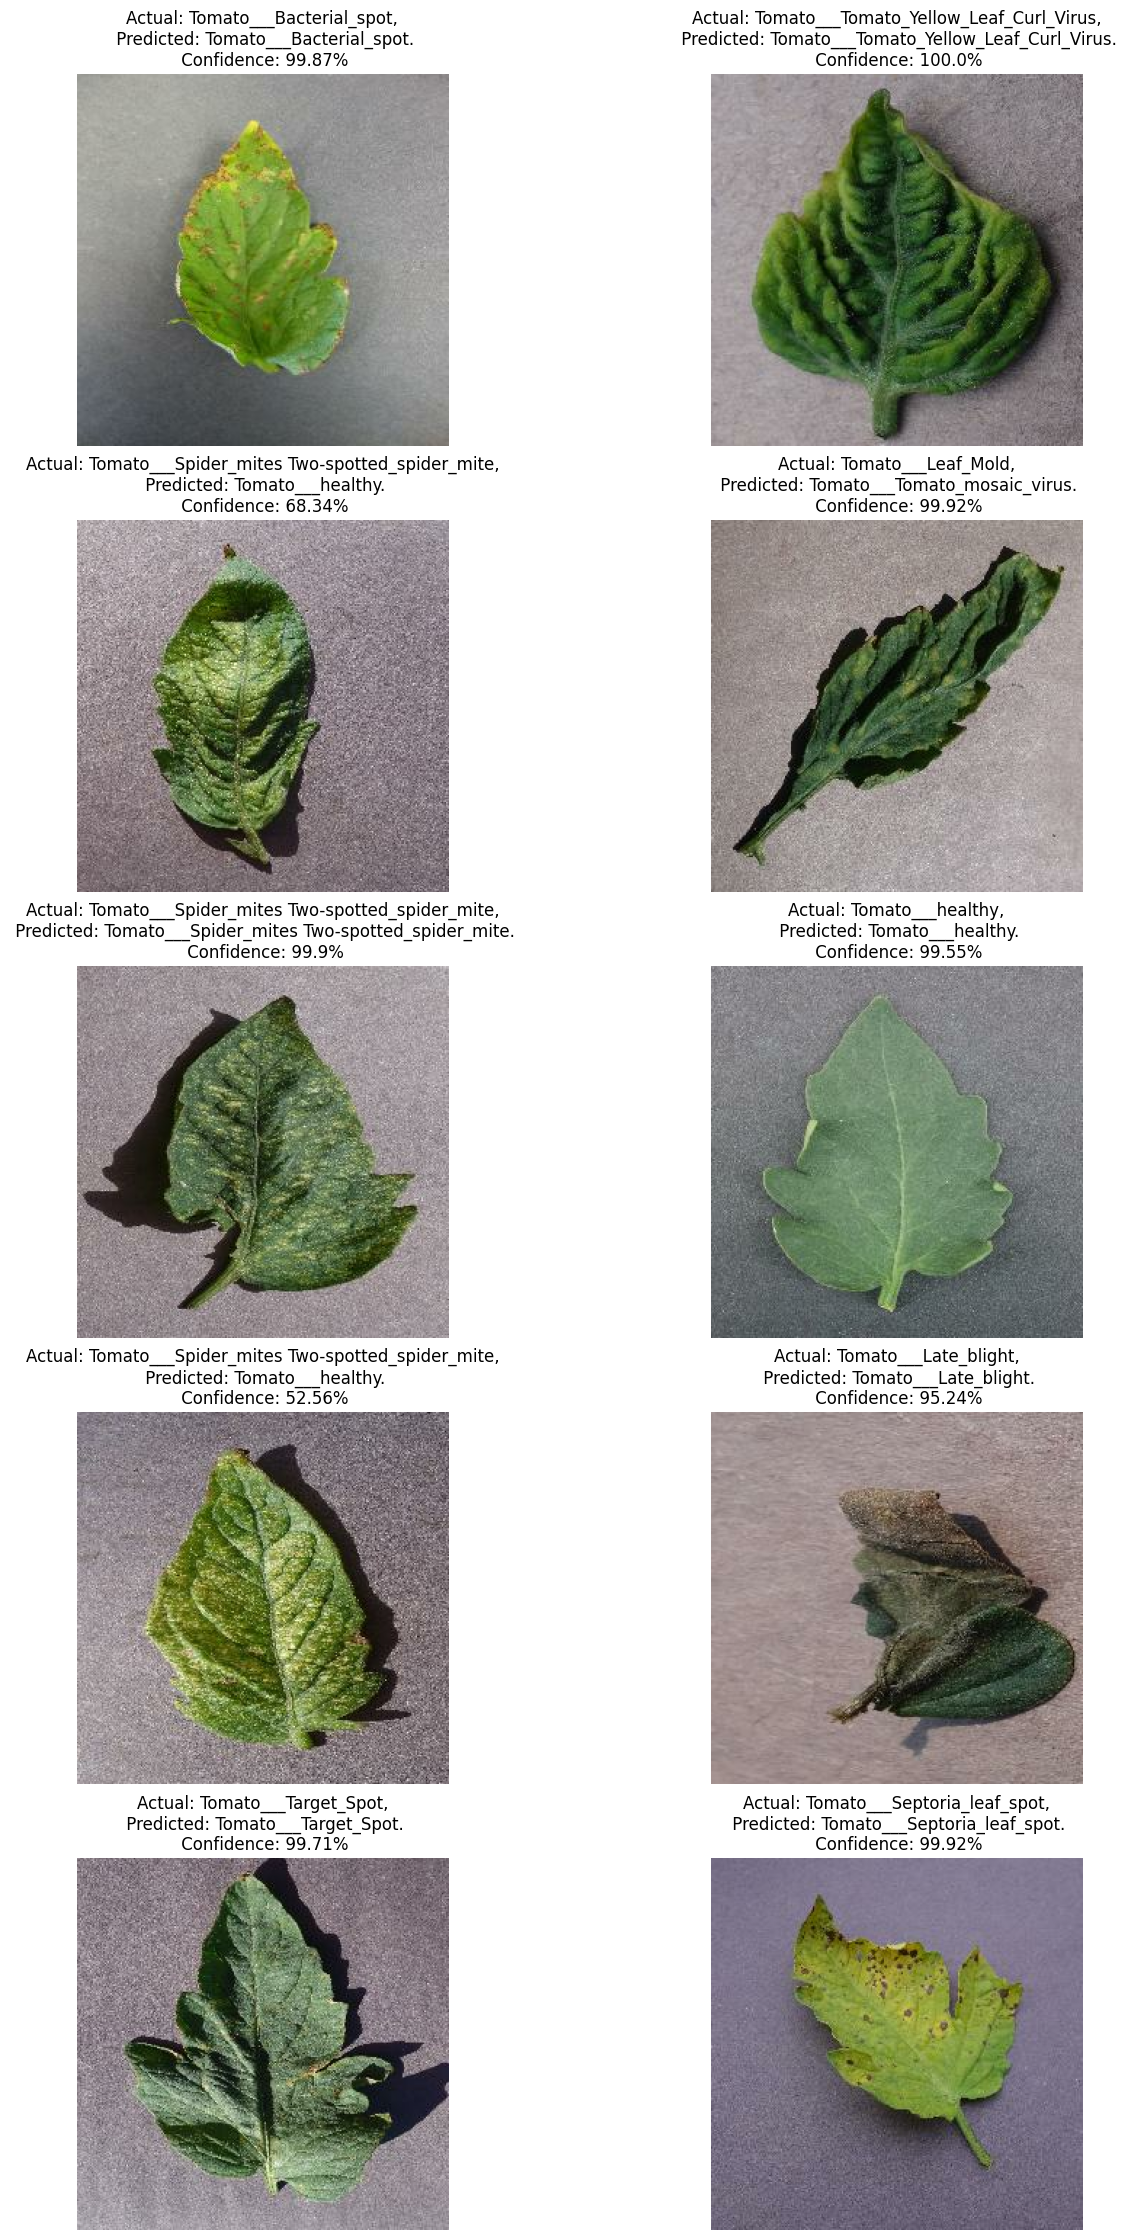

In [6]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 28))
for images, labels in test_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")